In [1]:
#Round2
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Paths (adjust base_path as needed)
base_path = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-2'
train_subfolders = ['90%Base', 'Th1', 'Th2', 'Th3']

# Individual corrected paths
level1_path = os.path.join(base_path, 'Level1', '10%Base')
level2_path = os.path.join(base_path, 'Level2', 'Inbox')
level3_path = os.path.join(base_path, 'Level3', 'Outbox')
training_paths = [os.path.join(base_path, 'Training', sub) for sub in train_subfolders]

# Round 2 dataset directories
r2_train_dir = 'round2_dataset/train'
r2_test1_dir = 'round2_dataset/test1'
r2_test2_dir = 'round2_dataset/test2'
r2_test3_dir = 'round2_dataset/test3'

# Clean and recreate folders
for folder in [r2_train_dir, r2_test1_dir, r2_test2_dir, r2_test3_dir]:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

# Function to copy images
def split_and_copy(src_folder, dst_folder, split_ratio=1.0, split_type='random'):
    if not os.path.exists(src_folder):
        print(f" Source folder does not exist: {src_folder}")
        return
    labels = os.listdir(src_folder)
    for label in labels:
        src_label_path = os.path.join(src_folder, label)
        if not os.path.isdir(src_label_path):
            continue
        dst_label_path = os.path.join(dst_folder, label)
        os.makedirs(dst_label_path, exist_ok=True)

        files = [f for f in os.listdir(src_label_path)
                 if os.path.isfile(os.path.join(src_label_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        files.sort()

        if not files:
            print(f" No image files found in {src_label_path}")
            continue

        if split_type == 'random':
            files = random.sample(files, int(len(files) * split_ratio))
        elif split_type == 'first_half':
            files = files[:int(len(files) * split_ratio)]
        elif split_type == 'second_half':
            files = files[int(len(files) * split_ratio):]

        for f in files:
            shutil.copy(os.path.join(src_label_path, f), os.path.join(dst_label_path, f))
        print(f" Copied {len(files)} files for label '{label}' to {dst_folder}\\{label}")

# Build training set
for path in training_paths:
    split_and_copy(path, r2_train_dir)

# Test1: 10% base from Level1
split_and_copy(level1_path, r2_test1_dir)

# Test2: All Inbox from Level2
split_and_copy(level2_path, r2_test2_dir)

# Test3: Outbox split
split_and_copy(level3_path, r2_train_dir, 0.5, split_type='first_half')  # Add to train
split_and_copy(level3_path, r2_test3_dir, 0.5, split_type='second_half')  # Test

# Image generators
img_size = (128, 128)
batch_size = 16
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(r2_train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test1_data = datagen.flow_from_directory(r2_test1_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test2_data = datagen.flow_from_directory(r2_test2_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test3_data = datagen.flow_from_directory(r2_test3_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

 Copied 351 files for label 'D0' to round2_dataset/train\D0
 Copied 350 files for label 'D1' to round2_dataset/train\D1
 Copied 350 files for label 'D2' to round2_dataset/train\D2
 Copied 32 files for label 'D0' to round2_dataset/train\D0
 Copied 33 files for label 'D2' to round2_dataset/train\D2
 Copied 33 files for label 'D0' to round2_dataset/train\D0
 Copied 31 files for label 'D2' to round2_dataset/train\D2
 Copied 35 files for label 'D0' to round2_dataset/train\D0
 Copied 33 files for label 'D2' to round2_dataset/train\D2
 Copied 52 files for label 'D0' to round2_dataset/test1\D0
 Copied 43 files for label 'D1' to round2_dataset/test1\D1
 Copied 48 files for label 'D2' to round2_dataset/test1\D2
 Copied 174 files for label 'D0' to round2_dataset/test2\D0
 Copied 180 files for label 'D1' to round2_dataset/test2\D1
 Copied 180 files for label 'D2' to round2_dataset/test2\D2
 Copied 126 files for label 'D0' to round2_dataset/train\D0
 Copied 72 files for label 'D1' to round2_dataset

In [3]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'round2_dataset/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'round2_dataset/test1',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1507 images belonging to 3 classes.
Found 143 images belonging to 3 classes.


In [4]:

# Build DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base_model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# Train model
history = model.fit(train_generator, epochs=25, validation_data=test_generator)

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.3380 - loss: 1.4089 - val_accuracy: 0.3007 - val_loss: 1.1525
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.3319 - loss: 1.3116 - val_accuracy: 0.3636 - val_loss: 1.1139
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3630 - loss: 1.2490 - val_accuracy: 0.3566 - val_loss: 1.0899
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3522 - loss: 1.2306 - val_accuracy: 0.4755 - val_loss: 1.0673
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.3791 - loss: 1.1779 - val_accuracy: 0.4336 - val_loss: 1.0579
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.3663 - loss: 1.1676 - val_accuracy: 0.4336 - val_loss: 1.0597
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.3950 - loss: 1.1582 - val_accuracy: 0.4056 - val_loss: 1.0613
Epoch 8/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.3851 - loss: 1.1335 - val_accuracy: 0.5035 - val_loss

In [10]:
# Train model
history = model.fit(train_generator, epochs=25, validation_data=test_generator)

Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.4782 - loss: 1.0347 - val_accuracy: 0.5524 - val_loss: 0.9696
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4597 - loss: 1.0474 - val_accuracy: 0.5874 - val_loss: 0.9577
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.4808 - loss: 1.0422 - val_accuracy: 0.6434 - val_loss: 0.9645
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.4785 - loss: 1.0316 - val_accuracy: 0.6294 - val_loss: 0.9608
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4753 - loss: 1.0484 - val_accuracy: 0.5804 - val_loss: 0.9530
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4948 - loss: 1.0265 - val_accuracy: 0.6014 - val_loss: 0.9537
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.4822 - loss: 1.0292 - val_accuracy: 0.6154 - val_loss: 0.9580
Epoch 8/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.4786 - loss: 1.0076 - val_accuracy: 0.6294 - val_loss:

In [11]:
# Evaluate model
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n DenseNet121 - Training Accuracy: {train_acc:.4f}")
print(f" DenseNet121 - Testing Accuracy: {test_acc:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.6068 - loss: 0.9347
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6830 - loss: 0.9064

 DenseNet121 - Training Accuracy: 0.6005
 DenseNet121 - Testing Accuracy: 0.6713


In [12]:
# Evaluate on Test2 and Test3
test1_loss, test1_acc = model.evaluate(test1_data, verbose=0)
print(f"Test1 (Inbox) Accuracy: {test1_acc * 100:.2f}%")
test2_loss, test2_acc = model.evaluate(test2_data, verbose=0)
print(f"Test2 (Inbox) Accuracy: {test2_acc * 100:.2f}%")
test3_loss, test3_acc = model.evaluate(test3_data, verbose=0)
print(f"Test3 (Outbox) Accuracy: {test3_acc * 100:.2f}%")

Test1 (Inbox) Accuracy: 36.36%
Test2 (Inbox) Accuracy: 34.08%
Test3 (Outbox) Accuracy: 41.36%


In [13]:
# Predictions and evaluation
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step



Classification Report:
              precision    recall  f1-score   support

          D0       0.67      0.79      0.73        52
          D1       0.80      0.47      0.59        43
          D2       0.61      0.73      0.67        48

    accuracy                           0.67       143
   macro avg       0.70      0.66      0.66       143
weighted avg       0.69      0.67      0.66       143



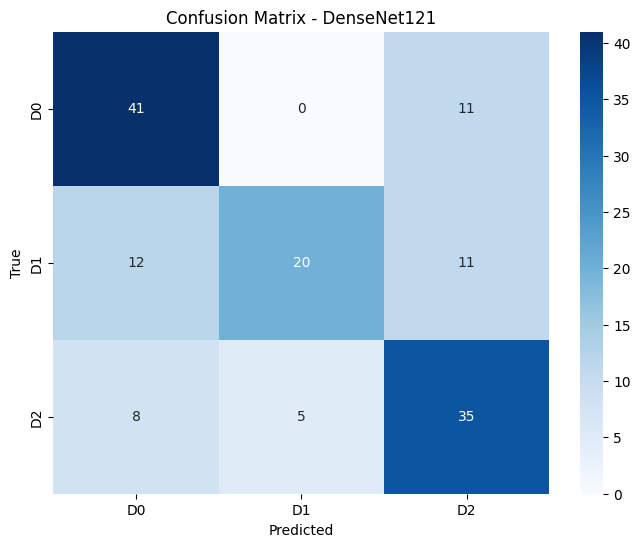

In [15]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title("Confusion Matrix - DenseNet121")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step

Classification Report (Test1):
              precision    recall  f1-score   support

          D0       0.38      0.92      0.54        52
          D1       0.00      0.00      0.00        43
          D2       0.25      0.08      0.12        48

    accuracy                           0.36       143
   macro avg       0.21      0.34      0.22       143
weighted avg       0.22      0.36      0.24       143

Confusion Matrix (Test1):


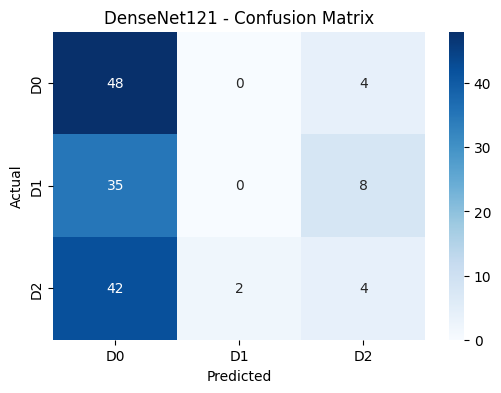

In [16]:
# Classification report and confusion matrix (on test1)
y_true = test1_data.classes
y_pred = np.argmax(model.predict(test1_data), axis=1)
class_labels = list(test1_data.class_indices.keys())

print("\nClassification Report (Test1):")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix (Test1):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet121 - Confusion Matrix')
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 386ms/step

Classification Report (Test2):
              precision    recall  f1-score   support

          D0       0.33      0.91      0.49       174
          D1       0.50      0.02      0.03       180
          D2       0.41      0.11      0.17       180

    accuracy                           0.34       534
   macro avg       0.41      0.35      0.23       534
weighted avg       0.41      0.34      0.23       534

Confusion Matrix (Test2):


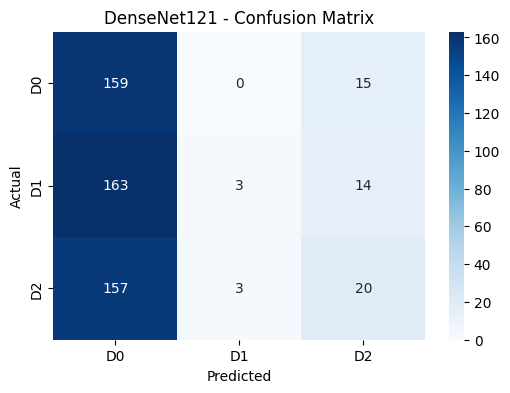

In [17]:
# Classification report and confusion matrix (on test2)
y_true = test2_data.classes
y_pred = np.argmax(model.predict(test2_data), axis=1)
class_labels = list(test2_data.class_indices.keys())

print("\nClassification Report (Test2):")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix (Test2):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet121 - Confusion Matrix')
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 400ms/step

Classification Report (Test3):
              precision    recall  f1-score   support

          D0       0.40      0.98      0.57       126
          D1       0.00      0.00      0.00        72
          D2       0.79      0.09      0.16       126

    accuracy                           0.41       324
   macro avg       0.40      0.35      0.24       324
weighted avg       0.46      0.41      0.28       324

Confusion Matrix (Test3):


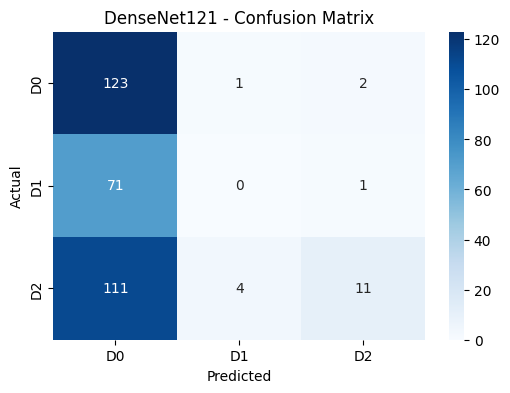

In [18]:
# Classification report and confusion matrix (on test3)
y_true = test3_data.classes
y_pred = np.argmax(model.predict(test3_data), axis=1)
class_labels = list(test3_data.class_indices.keys())

print("\nClassification Report (Test3):")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix (Test3):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet121 - Confusion Matrix')
plt.show()

In [1]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Paths (adjust base_path if needed)
base_path = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-2'
level1_path = os.path.join(base_path, 'Level1', '10%Base')
level2_path = os.path.join(base_path, 'Level2', 'Inbox')
level3_path = os.path.join(base_path, 'Level3', 'Outbox')
training_path = os.path.join(base_path, 'Training')

# Image settings
img_size = (224, 224)
batch_size = 4

# Image generators
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    training_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test1_generator = datagen.flow_from_directory(
    level1_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1248 images belonging to 4 classes.
Found 143 images belonging to 3 classes.


In [18]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Paths (adjust base_path as needed)
base_path = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-2'
train_subfolders = ['90%Base', 'Th1', 'Th2', 'Th3']

# Individual corrected paths
level1_path = os.path.join(base_path, 'Level1', '10%Base')
level2_path = os.path.join(base_path, 'Level2', 'Inbox')
level3_path = os.path.join(base_path, 'Level3', 'Outbox')
training_paths = [os.path.join(base_path, 'Training', sub) for sub in train_subfolders]

# Round 2 dataset directories
r2_train_dir = 'round2_dataset/train'
r2_test1_dir = 'round2_dataset/test1'
r2_test2_dir = 'round2_dataset/test2'
r2_test3_dir = 'round2_dataset/test3'

# Clean and recreate folders
for folder in [r2_train_dir, r2_test1_dir, r2_test2_dir, r2_test3_dir]:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

# Function to copy images
def split_and_copy(src_folder, dst_folder, split_ratio=1.0, split_type='random'):
    if not os.path.exists(src_folder):
        print(f"❌ Source folder does not exist: {src_folder}")
        return
    labels = os.listdir(src_folder)
    for label in labels:
        src_label_path = os.path.join(src_folder, label)
        if not os.path.isdir(src_label_path):
            continue
        dst_label_path = os.path.join(dst_folder, label)
        os.makedirs(dst_label_path, exist_ok=True)

        files = [f for f in os.listdir(src_label_path)
                 if os.path.isfile(os.path.join(src_label_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        files.sort()

        if not files:
            print(f"⚠️ No image files found in {src_label_path}")
            continue

        if split_type == 'random':
            files = random.sample(files, int(len(files) * split_ratio))
        elif split_type == 'first_half':
            files = files[:int(len(files) * split_ratio)]
        elif split_type == 'second_half':
            files = files[int(len(files) * split_ratio):]

        for f in files:
            shutil.copy(os.path.join(src_label_path, f), os.path.join(dst_label_path, f))
        print(f"✅ Copied {len(files)} files for label '{label}' to {dst_folder}\\{label}")

# Build training set
for path in training_paths:
    split_and_copy(path, r2_train_dir)

# Test1: 10% base from Level1
split_and_copy(level1_path, r2_test1_dir)

# Test2: All Inbox from Level2
split_and_copy(level2_path, r2_test2_dir)

# Test3: Outbox split
split_and_copy(level3_path, r2_train_dir, 0.5, split_type='first_half')  # Add to train
split_and_copy(level3_path, r2_test3_dir, 0.5, split_type='second_half')  # Test

# Image generators
img_size = (150, 150)
batch_size = 16
datagen = ImageDataGenerator(rescale=1./255)
train_data = datagen.flow_from_directory(r2_train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test1_data = datagen.flow_from_directory(r2_test1_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test2_data = datagen.flow_from_directory(r2_test2_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test3_data = datagen.flow_from_directory(r2_test3_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)



✅ Copied 351 files for label 'D0' to round2_dataset/train\D0
✅ Copied 350 files for label 'D1' to round2_dataset/train\D1
✅ Copied 350 files for label 'D2' to round2_dataset/train\D2
✅ Copied 32 files for label 'D0' to round2_dataset/train\D0
✅ Copied 33 files for label 'D2' to round2_dataset/train\D2
✅ Copied 33 files for label 'D0' to round2_dataset/train\D0
✅ Copied 31 files for label 'D2' to round2_dataset/train\D2
✅ Copied 35 files for label 'D0' to round2_dataset/train\D0
✅ Copied 33 files for label 'D2' to round2_dataset/train\D2
✅ Copied 52 files for label 'D0' to round2_dataset/test1\D0
✅ Copied 43 files for label 'D1' to round2_dataset/test1\D1
✅ Copied 48 files for label 'D2' to round2_dataset/test1\D2
✅ Copied 174 files for label 'D0' to round2_dataset/test2\D0
✅ Copied 180 files for label 'D1' to round2_dataset/test2\D1
✅ Copied 180 files for label 'D2' to round2_dataset/test2\D2
✅ Copied 126 files for label 'D0' to round2_dataset/train\D0
✅ Copied 72 files for label 'D1' 

In [19]:
from tensorflow.keras.applications import InceptionV3

# Set the image size to 150x150 for InceptionV3
img_size = (150, 150)

# Initialize the InceptionV3 model with the appropriate input size
base_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

# Add the top layers (fully connected layers)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,934,115 (83.67 MB)

 Trainable params: 21,899,683 (83.54 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [20]:
#Train the model
history = model.fit(train_data, epochs=10, validation_data=test1_data)



Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.4489 - loss: 1.1605 - val_accuracy: 0.3357 - val_loss: 3.0077
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 881ms/step - accuracy: 0.6660 - loss: 0.6858 - val_accuracy: 0.5245 - val_loss: 1.0922
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 92s 972ms/step - accuracy: 0.7800 - loss: 0.4518 - val_accuracy: 0.7832 - val_loss: 0.4578
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 81s 853ms/step - accuracy: 0.8652 - loss: 0.3120 - val_accuracy: 0.9231 - val_loss: 0.2176
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9214 - loss: 0.2181 - val_accuracy: 0.3077 - val_loss: 6.6719
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 81s 848ms/step - accuracy: 0.9192 - loss: 0.2224 - val_accuracy: 0.9650 - val_loss: 0.1040
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 862ms/step - accuracy: 0.9594 - loss: 0.1316 - val_accuracy: 0.9580 - val_loss: 0.1062
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 866ms/step - accuracy: 0.9738 - loss: 0.0775 - val_accuracy

In [21]:
# Print final training and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"\n✅ Final Training Accuracy: {train_acc:.4f}")
print(f"✅ Final Validation Accuracy (Test1 - 10%Base): {val_acc:.4f}")



✅ Final Training Accuracy: 0.9781
✅ Final Validation Accuracy (Test1 - 10%Base): 0.9161



 Evaluation on Test1 (10%Base)
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 524ms/step
 Accuracy on Test1 (10%Base): 0.9161

Classification Report:
              precision    recall  f1-score   support

          D0       0.96      1.00      0.98        52
          D1       1.00      0.72      0.84        43
          D2       0.83      1.00      0.91        48

    accuracy                           0.92       143
   macro avg       0.93      0.91      0.91       143
weighted avg       0.93      0.92      0.91       143



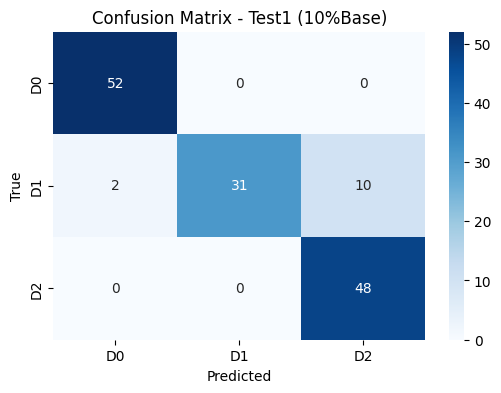


 Evaluation on Test2 (Inbox)


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step
 Accuracy on Test2 (Inbox): 0.7566

Classification Report:
              precision    recall  f1-score   support

          D0       0.89      0.99      0.94       174
          D1       0.89      0.34      0.50       180
          D2       0.63      0.94      0.75       180

    accuracy                           0.76       534
   macro avg       0.80      0.76      0.73       534
weighted avg       0.80      0.76      0.73       534



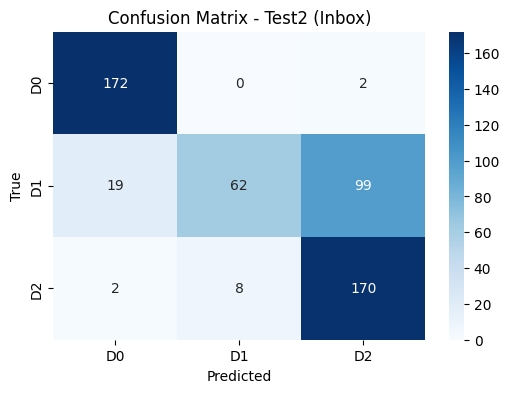


 Evaluation on Test3 (Outbox)


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step
 Accuracy on Test3 (Outbox): 0.5216

Classification Report:
              precision    recall  f1-score   support

          D0       0.59      0.65      0.62       126
          D1       0.39      0.35      0.37        72
          D2       0.52      0.49      0.50       126

    accuracy                           0.52       324
   macro avg       0.50      0.50      0.50       324
weighted avg       0.52      0.52      0.52       324



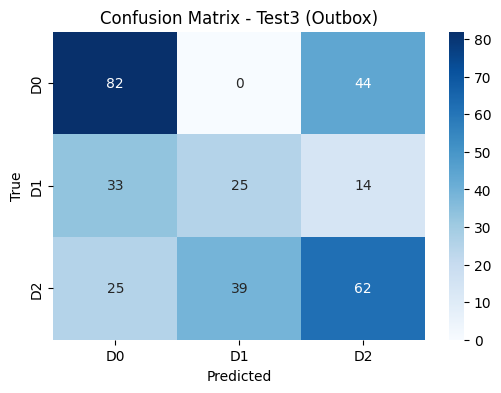

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

def evaluate_model(test_data, test_name):
    print(f"\n Evaluation on {test_name}")
    
    # Predict
    Y_pred = model.predict(test_data)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_data.classes
    class_labels = list(test_data.class_indices.keys())
    
    # Accuracy
    acc = np.mean(y_pred == y_true)
    print(f" Accuracy on {test_name}: {acc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {test_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Call function for all test sets
evaluate_model(test1_data, "Test1 (10%Base)")
evaluate_model(test2_data, "Test2 (Inbox)")
evaluate_model(test3_data, "Test3 (Outbox)")


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.72      0.84        43
           2       0.83      1.00      0.91        48

    accuracy                           0.92       143
   macro avg       0.93      0.91      0.91       143
weighted avg       0.93      0.92      0.91       143



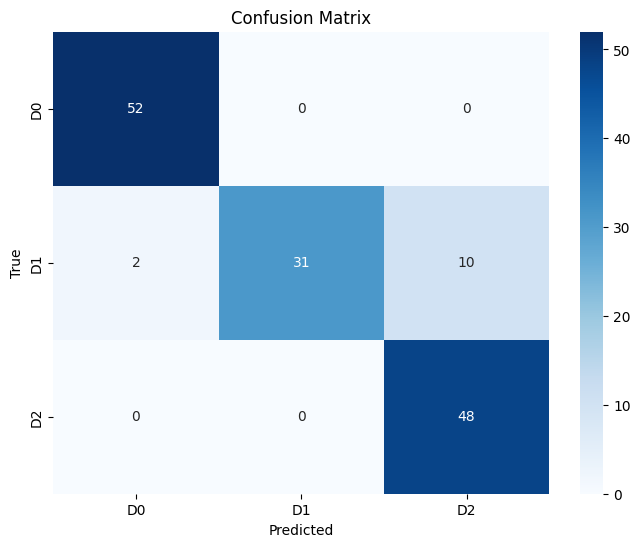

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict on the test data
test_predictions = model.predict(test1_data)

# Convert the predicted probabilities to class labels
test_predictions_class = np.argmax(test_predictions, axis=1)

# Step 2: Get the true labels
true_labels = test1_data.classes

# Step 3: Generate classification report
print("Classification Report:")
print(classification_report(true_labels, test_predictions_class))

# Step 4: Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, test_predictions_class)

# Step 5: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test1_data.class_indices.keys(), yticklabels=test1_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [26]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

# --- CONFIGURABLE PART ---
round3_base_path = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-3'
percent_folder = '25'

base_percent_path = os.path.join(round3_base_path, percent_folder)
level1_path = os.path.join(base_percent_path, 'Level1', '10%Base')
level2_path = os.path.join(base_percent_path, 'Level2', 'Inbox')
level3_path = os.path.join(base_percent_path, 'Level3', 'Outbox')
training_root = os.path.join(base_percent_path, 'Training')

training_subfolders = ['90%Base', 'Th1', 'Th2', 'Th3']
training_paths = [os.path.join(training_root, sub) for sub in training_subfolders]

# --- TEMP WORKING DIRECTORIES ---
r3_train_dir = f'round3_{percent_folder}/train'
r3_test1_dir = f'round3_{percent_folder}/test1'
r3_test2_dir = f'round3_{percent_folder}/test2'
r3_test3_dir = f'round3_{percent_folder}/test3'

for folder in [r3_train_dir, r3_test1_dir, r3_test2_dir, r3_test3_dir]:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

# --- UTILITY FUNCTION ---
def split_and_copy(src_folder, dst_folder):
    labels = os.listdir(src_folder)
    for label in labels:
        src_label_path = os.path.join(src_folder, label)
        dst_label_path = os.path.join(dst_folder, label)
        os.makedirs(dst_label_path, exist_ok=True)

        files = [f for f in os.listdir(src_label_path)
                 if os.path.isfile(os.path.join(src_label_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for f in files:
            shutil.copy(os.path.join(src_label_path, f), os.path.join(dst_label_path, f))

# --- BUILD TRAINING DATA ---
for path in training_paths:
    split_and_copy(path, r3_train_dir)

# --- BUILD TEST SETS ---
split_and_copy(level1_path, r3_test1_dir)
split_and_copy(level2_path, r3_test2_dir)
split_and_copy(level3_path, r3_test3_dir)

# --- IMAGE GENERATORS ---
img_size = (299, 299)
batch_size = 16
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = datagen.flow_from_directory(r3_train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test1_data = datagen.flow_from_directory(r3_test1_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test2_data = datagen.flow_from_directory(r3_test2_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test3_data = datagen.flow_from_directory(r3_test3_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# --- INCEPTIONV3 MODEL ---
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base_model layers (optional)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Found 1404 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Found 534 images belonging to 3 classes.
Found 648 images belonging to 3 classes.


In [27]:

# --- TRAIN MODEL ---
history = model.fit(train_data, epochs=10, validation_data=test1_data)


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2520']
Received: inputs=Tensor(shape=(None, 299, 299, 3))
  warnings.warn(msg)


88/88 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.3793 - loss: 1.2011 - val_accuracy: 0.4650 - val_loss: 1.0494
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.5159 - loss: 0.9891 - val_accuracy: 0.5032 - val_loss: 0.9610
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.5674 - loss: 0.9117 - val_accuracy: 0.5732 - val_loss: 0.9141
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.5856 - loss: 0.8813 - val_accuracy: 0.6306 - val_loss: 0.8655
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.6203 - loss: 0.8262 - val_accuracy: 0.5924 - val_loss: 0.9206
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.6338 - loss: 0.7765 - val_accuracy: 0.5860 - val_loss: 1.0032
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6079 - loss: 0.8190 - val_accuracy: 0.5478 - val_loss: 1.0767
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.6315 - loss: 0.7884 - val_accuracy: 0.6433 - val_loss: 0.8098
Epo

In [28]:

# --- FINAL ACCURACY ON LEVEL1 ---
print(f"\n Final Accuracy on Level1 (10% Base):")
test_loss1, test_acc1 = model.evaluate(test1_data)
print(f"Level1 Accuracy: {test_acc1:.4f}")

print("\n Final Accuracy on Level2 (Inbox):")
test_loss2, test_acc2 = model.evaluate(test2_data)
print(f"Level2 Accuracy: {test_acc2:.4f}")

print("\n Final Accuracy on Level3 (Outbox):")
test_loss3, test_acc3 = model.evaluate(test3_data)
print(f"Level3 Accuracy: {test_acc3:.4f}")





 Final Accuracy on Level1 (10% Base):
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 794ms/step - accuracy: 0.6027 - loss: 0.8284
Level1 Accuracy: 0.6051

 Final Accuracy on Level2 (Inbox):
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 817ms/step - accuracy: 0.5407 - loss: 0.9911
Level2 Accuracy: 0.5206

 Final Accuracy on Level3 (Outbox):
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 923ms/step - accuracy: 0.6231 - loss: 0.8857
Level3 Accuracy: 0.5880


In [29]:

# --- OVERALL ACCURACY ---
def get_all_predictions(data_gen):
    predictions = model.predict(data_gen, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = data_gen.classes
    return true_classes, predicted_classes

true1, pred1 = get_all_predictions(test1_data)
true2, pred2 = get_all_predictions(test2_data)
true3, pred3 = get_all_predictions(test3_data)

all_true = np.concatenate([true1, true2, true3])
all_pred = np.concatenate([pred1, pred2, pred3])

overall_acc = accuracy_score(all_true, all_pred)
print(f"\n Overall Accuracy across all levels: {overall_acc:.4f}")


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2520']
Received: inputs=Tensor(shape=(16, 299, 299, 3))
  warnings.warn(msg)



 Overall Accuracy across all levels: 0.5631



 Classification Report:
              precision    recall  f1-score   support

          D0       0.79      0.57      0.66       484
          D1       0.40      0.61      0.49       370
          D2       0.59      0.52      0.55       485

    accuracy                           0.56      1339
   macro avg       0.59      0.57      0.57      1339
weighted avg       0.61      0.56      0.57      1339



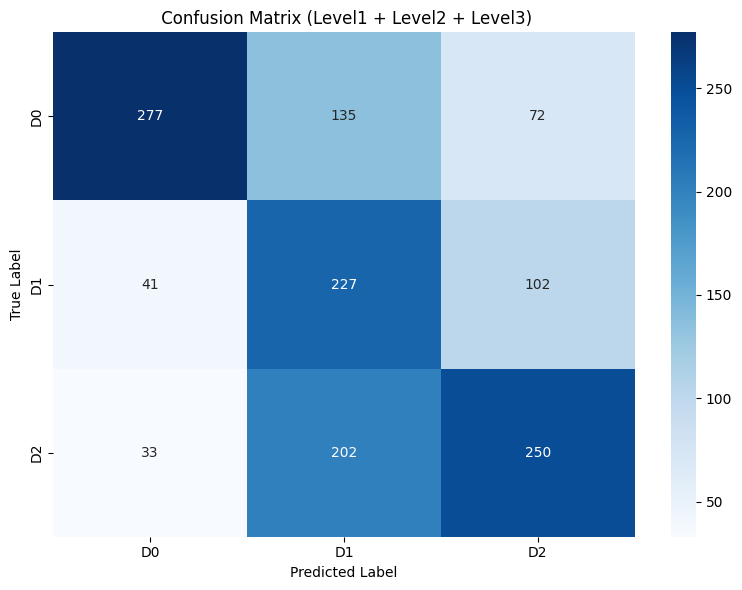

In [ ]:

# --- CLASSIFICATION REPORT & CONFUSION MATRIX ---
print("\n Classification Report:")

target_names = list(test1_data.class_indices.keys())
print(classification_report(all_true, all_pred, target_names=target_names))

cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(' Confusion Matrix (Level1 + Level2 + Level3)')
plt.tight_layout()
plt.show()
